# Image time frame normalization approach

In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.models import Sequential
from keras.layers import MaxPooling2D, Conv2D, Reshape, Dense, Flatten, Dropout
from sys import getsizeof
from sklearn.metrics import mean_squared_error

D:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data extraction methods

In [2]:
# Where you put the image file,
# It can be either relative or absolute path
image_folder = "MultiModHandGestUAV"

# Keep track of how much RAM we have used
class RAM(object):
    def __init__(self):
        self.RAM = 0

    def add(self, new_size):
        self.RAM += new_size

    def __str__(self):
        if self.RAM <= 1e3:
            return ("%dB" % self.RAM).lstrip()
        if self.RAM <= 1e6:
            return ("%6.2fKB" % (self.RAM / 1e3)).lstrip()
        elif self.RAM <= 1e9:
            return ("%6.2fMB" % (self.RAM / 1e6)).lstrip()
        else:
            return ("%6.2fGB" % (self.RAM / 1e9)).lstrip()

    def __rep__(self):
        return self.__str__()

RAMTracker = RAM()

#Match a label in str into a unique int
Label_Matcher = []

#Input shpae, 120 rows, 320 columns. Each cell has 1 dimension of colour
INPUT_SHAPE = (120,320,1)

def _break_down_path(image_path):
    """
    Break down the path image_path into 5 components and return them:
    1. subject: the subject number (in str) 
    2. is_sequence = "sequence" if not static image
    3. label: Which action the sequence is 
    4. typ: either "train" or "test"
    5. sequence_no, "seq_x"
    **Please note if the folder is for static images, the components break-down 
      will not be correct. You can check if sequence_no starts with "seq_" for confirmation 
    """
    #Image_path looks like "MultiModHandGestUAV\00\sequences\cam_f\train\seq_0"
    image_path, sequence_no = os.path.split(image_path)
    image_path, typ = os.path.split(image_path)
    image_path, label = os.path.split(image_path)
    image_path, is_sequence = os.path.split(image_path)
    _, subject = os.path.split(image_path)
    return subject, is_sequence, label, typ, sequence_no


def get_seq_path(subject_nos=None, gesture_names=None, target_type = "train"):
    """
    Given an array of numbers in subject_nos, or names in gesture_names
    returns a list where each row is tuple(image_fullpath, label, seq_uid, which_frame, total_frame_in_sequence)
    seq_uid = subject_number + sequence_no + label, used to uniquely identify a sequence.
    """
    result = []
    
    #Path would look like "MultiModHandGestUAV\00\sequences\cam_f\train\seq_0"
    for folder, sub_folders, files in os.walk(image_folder):
        if len(sub_folders) == 0 and len(files) > 0:  #Reached a folder with no subfolder
            subject, is_sequence, label, typ, sequence_no = _break_down_path(folder)
            
            if sequence_no.startswith("seq_") and \
                (int(subject) in subject_nos if subject_nos is not None else True) and \
                (label in gesture_names if gesture_names is not None else True) and \
                typ == target_type:
                num_files = len(files)
                seq_uid = "%s|%s|%s" % (subject, sequence_no, label)
                for i in range(num_files):
                    result.append(tuple([os.path.join(folder, files[i]), label, seq_uid, i ,num_files]))
    return result


def read_image(fullpath):
    """
    Read a single image specified fullpath
    """
    img = Image.open(fullpath).convert('L')
    img = img.resize((INPUT_SHAPE[1], INPUT_SHAPE[0]))
    result = np.array(img).reshape(INPUT_SHAPE) / 255.0
    return result


def process_image_rows(image_file_data):
    """
    Read the tuple list returned by get_seq_path and convert them into x, y, l np_arry
    where x is the np array of all images, l is the label array, and y is the normalized timestamp
    """
    #each row is tuple(image_fullpath, label, which_frame, total_frame_in_sequence)
    x = []
    y = []
    l = []
    
    for row in image_file_data:
        x.append(read_image(row[0]))
        y.append(row[3]/row[4])
        l.append(row[1])
    
    x = np.array(x, dtype="float32")
    y = np.array(y, dtype="float32")
    l = np.array(l)
    
    return x, y, l


## Get Train Data

In [4]:
image_data = get_seq_path(subject_nos=[0,1,], target_type="train")
RAMTracker.add(getsizeof(image_data))
print("After image_path, RAM usage: %s\n" % str(RAMTracker))

x_train, y_train, l_train = process_image_rows(image_data)
RAMTracker.add(getsizeof(x_train) + getsizeof(y_train) + getsizeof(l_train))
print("After train_data, RAM usage: %s\n" % str(RAMTracker))

print("Label -> Unique ID match")
Label_Matcher = list(np.unique(l_train))
Label_Matcher = dict([(Label_Matcher[i], i) for i in range(len(Label_Matcher))])
print("\n".join(["%d: %s" % (Label_Matcher[i], i) for i in Label_Matcher]))
print()

print("X Train shape:", x_train.shape)

After image_path, RAM usage: 197.25KB

After train_data, RAM usage: 1.79GB

Label -> Unique ID match
0: cam_b
1: cam_f
2: cam_l
3: cam_r
4: down
5: ele
6: left
7: right
8: up
9: zoom_in
10: zoom_out

X Train shape: (11624, 120, 320, 1)


## Get Test Data

In [5]:
image_data = get_seq_path(subject_nos=[0,1,], target_type="test")
test_image_data = np.array(image_data)

x_test, y_test, l_test = process_image_rows(image_data)
RAMTracker.add(getsizeof(x_test) + getsizeof(y_test) + getsizeof(l_test))
print("After test_data, RAM usage: %s\n" % str(RAMTracker))

print("X Test shape:", x_test.shape)

After test_data, RAM usage: 2.24GB

X Test shape: (2935, 120, 320, 1)


## Plot a few images

Training Images:


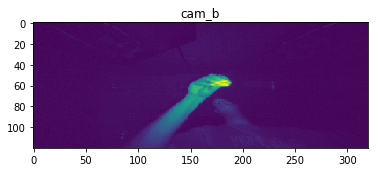

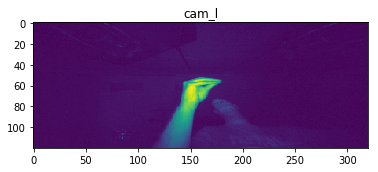

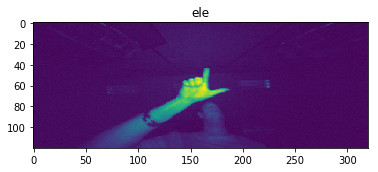

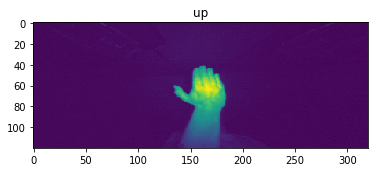

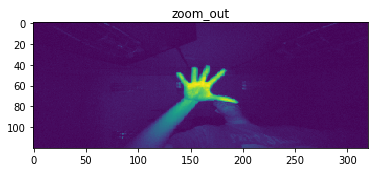

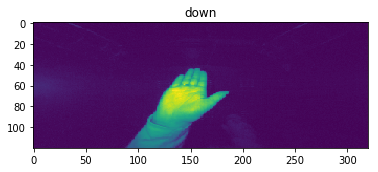

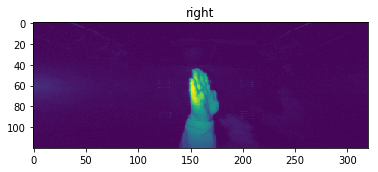

Test Images:


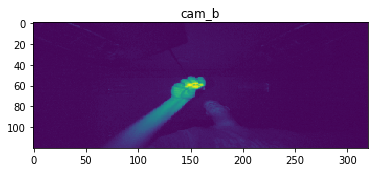

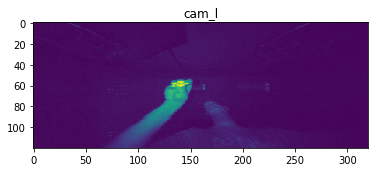

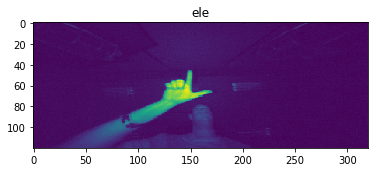

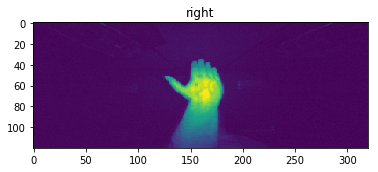

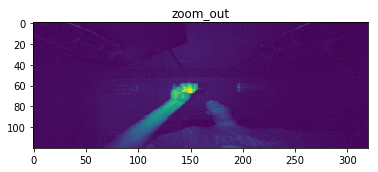

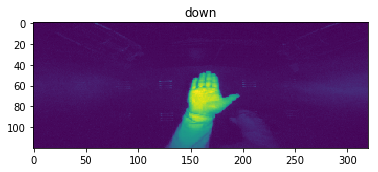

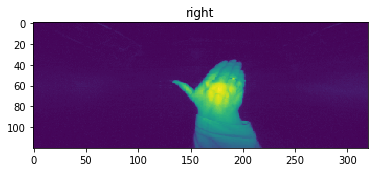

In [6]:
print("Training Images:")
for i in range(0, 7):
    plt.imshow(x_train[int(x_train.shape[0] / 7 * i)].reshape((INPUT_SHAPE[0], INPUT_SHAPE[1])))
    plt.title(l_train[int(x_train.shape[0] / 7 * i)])
    plt.show()
    
print("Test Images:")
for i in range(0, 7):
    plt.imshow(x_test[int(x_test.shape[0] / 7 * i)].reshape((INPUT_SHAPE[0], INPUT_SHAPE[1])))
    plt.title(l_test[int(x_test.shape[0] / 7 * i)])
    plt.show()

## Separate X_train into 11 labels

In [7]:
train_label_matcher = {}
for a_label in Label_Matcher:
    row_nos = np.where(l_train == a_label)
    train_label_matcher[a_label] = row_nos

test_label_matcher = {}
for a_label in Label_Matcher:
    row_nos = np.where(l_test == a_label)
    test_label_matcher[a_label] = row_nos

## Create 11 models, for the 11 labels

In [8]:
models = {}
from math import sqrt
first_print = True
for a_label in Label_Matcher:
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(4,4), strides=(1,1) , activation='relu',input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D (pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1) , activation='relu'))
    model.add(MaxPooling2D (pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1) , activation='relu'))
    model.add(MaxPooling2D (pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1) , activation='relu'))
    model.add(MaxPooling2D (pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(10,kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    if first_print:
        print(model.summary())
        first_print = False
    model.compile(loss='mean_squared_error', optimizer=tf.train.AdamOptimizer())
    print("For %s label" % a_label)
    for _ in range(20):
        model.fit(x_train[train_label_matcher[a_label]], y_train[train_label_matcher[a_label]], batch_size = 10)
    y_pred = model.predict(x_train[train_label_matcher[a_label]])
    print(y_pred.shape)
    print(y_train[train_label_matcher[a_label]].shape)
    print(sqrt(mean_squared_error(y_pred.ravel(), y_train[train_label_matcher[a_label]])))
    y_pred = model.predict(x_test[test_label_matcher[a_label]])
    print(y_pred.shape)
    print(y_test[test_label_matcher[a_label]].shape)
    print(sqrt(mean_squared_error(y_pred.ravel(), y_test[test_label_matcher[a_label]])))
    models[a_label] = model
    #break

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 117, 317, 64)      1088      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 158, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 154, 64)       102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 77, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 73, 64)        102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 36, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 32, 64)         102464    
__________

919/919 [==============================] - 3s 3ms/step - loss: 0.0102
Epoch 1/1
919/919 [==============================] - 3s 3ms/step - loss: 0.0104
Epoch 1/1
919/919 [==============================] - 3s 3ms/step - loss: 0.0097
Epoch 1/1
919/919 [==============================] - 3s 3ms/step - loss: 0.0092
(919, 1)
(919,)
0.11088807573246423
(219, 1)
(219,)
0.13628417839730106
For down label
Epoch 1/1
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0702
Epoch 1/1
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0277
Epoch 1/1
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0248
Epoch 1/1
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0232
Epoch 1/1
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0215
Epoch 1/1
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0211
Epoch 1/1
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0184
Epoch 1/1
1237/1237 [========

1122/1122 [==============================] - 3s 3ms/step - loss: 0.0117
Epoch 1/1
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0126
Epoch 1/1
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0101A: 0s - loss: 0.010
Epoch 1/1
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0104
Epoch 1/1
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0104
Epoch 1/1
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0078
Epoch 1/1
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0070
Epoch 1/1
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0067
Epoch 1/1
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0074
Epoch 1/1
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0059
(1122, 1)
(1122,)
0.061231216246622
(278, 1)
(278,)
0.13302658161487727
For zoom_in label
Epoch 1/1
861/861 [==============================] - 3s 3ms/step - loss: 0.0653A:

In [9]:
all_seqs = tuple(np.unique(test_image_data[:,2]))
seq_matcher = {}
for a_seq in all_seqs:
    matching_indices = np.where(test_image_data[:,2] == a_seq)
    seq_matcher[a_seq] = matching_indices
counter = 0

right = 0
wrong = 0
aaa = {}
bbb = {}
for a_seq in seq_matcher.keys():
    mse = {}
    lab = tuple(np.unique(l_test[seq_matcher[a_seq]]))
    for a_label in Label_Matcher:
        y_pred = models[a_label].predict(x_test[seq_matcher[a_seq]])
        mse[a_label] = mean_squared_error(y_pred.ravel(), y_test[seq_matcher[a_seq]])
    
    if min(mse, key=mse.get) == lab[0]:
        right += 1
    else:
        wrong += 1
        if lab[0] in aaa:
            aaa[lab[0]] += 1
        else:
            aaa[lab[0]] = 1
            
        if min(mse, key=mse.get) in bbb:
            bbb[min(mse, key=mse.get)] += 1
        else:
            bbb[min(mse, key=mse.get)] = 1
            
print(right, wrong, right/(right+wrong))
    
        

155 24 0.8659217877094972


In [10]:
print(aaa)
print(bbb)

{'right': 5, 'up': 3, 'cam_b': 2, 'ele': 10, 'zoom_out': 1, 'cam_r': 1, 'down': 1, 'zoom_in': 1}
{'zoom_in': 7, 'down': 2, 'up': 3, 'cam_r': 2, 'right': 3, 'cam_b': 2, 'zoom_out': 1, 'cam_f': 2, 'cam_l': 2}


In [13]:
print(155/(155+24-10))

0.9171597633136095
